# PROJECT PART 3

### 1. Choose a product to advertise by means of digital tools. Provide a brief description.

We have chosen shoes as a product because they provide a lot of variety, so they guarantee an high flexibility when targeting users. For this reason we think that they are a good choice for this project.

### 2. Imagine 5 advertising sub-campaigns. Imagine an average daily budget/clicks curve (providing, for every value of daily budget, the number of daily clicks) aggregating the curves of three different classes of users. Notice that, in order to define the curves, it is necessary the definition of probability distributions. Provide a description of the three classes of users. Note: the definition of the classes of the users must be done by introducing features and different values for the features (e.g., gender, interests, age).

## Curve generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
def user_clicks(bid, slope, x):
    slope = slope + add_noise(mu=0.01, std=0.05)
    return (1 - np.exp(slope*x))*10

In [3]:
def add_noise(mu=0, std=1):
    return np.random.normal(mu, std)

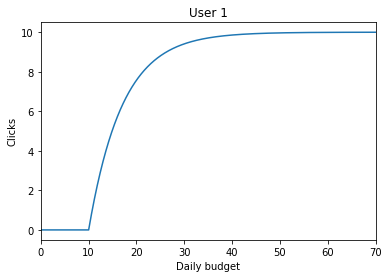

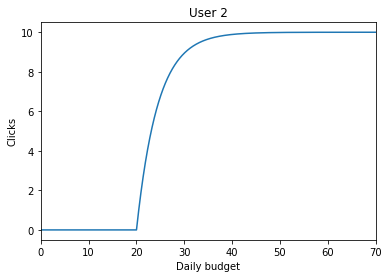

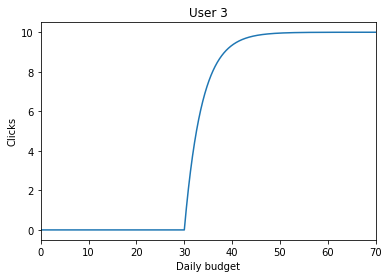

In [4]:
n_user = 3
num_click = np.array([])
slopes = [-0.1*(1), -0.1*(2), -0.1*(3)]

for user in range(n_user):
    bid = 10*(user+1)
    max_budget = 70
    
    # Linear space from 0 to bid value, y is 0 for everything.
    x_0 = np.linspace(0, bid, bid*20)
    y_0 = np.zeros(bid*20)

    # Linear space from bid value to max_budget, y is exponential.
    x_1 = np.linspace(bid, max_budget, max_budget*20)
    x = np.linspace(0, max_budget-bid, max_budget*20)
    y_1 = user_clicks(bid, slopes[user] , x)

    x = np.append(x_0, x_1)
    y = np.append(y_0, y_1)

    plt.plot(x, y)
    plt.title("User %d" % (user + 1))
    plt.xlabel("Daily budget")
    plt.xlim((0, max_budget))
    plt.ylabel("Clicks")
    plt.show()

## Curve aggregation

In [5]:
n_inf = float("-inf")
class Subcampaign:
    def __init__(self, bid, min_budget, max_budget, number_of_clicks):
        self.bid = bid
        self.min_budget = min_budget
        self.max_budget = max_budget
        self.number_of_clicks = number_of_clicks #function
    
    # x is budget
    def n(self,x):
        if x < self.min_budget:
            return n_inf
        elif x < self.bid:
            return 0
        elif x > self.max_budget:
            return n_inf
        else:
            return self.number_of_clicks(x)

### Init subcampaigns

In [6]:
subcampaigns = np.array([])

bid_1 = 2
bid_2 = 1
bid_3 = 0.5
bid_4 = 0.5
bid_5 = 1

n1 = partial(user_clicks, bid_1, slopes[0])
n2 = partial(user_clicks,bid_2, slopes[2])
n3 = partial(user_clicks,bid_3, slopes[0])
n4 = partial(user_clicks,bid_4, slopes[1])
n5 = partial(user_clicks,bid_5, slopes[2])

subcampaigns = np.append(subcampaigns, Subcampaign(2, 10, 40, n1))
subcampaigns = np.append(subcampaigns, Subcampaign(1, 0, 30, n2))
subcampaigns = np.append(subcampaigns, Subcampaign(0.5, 0, 40, n3))
subcampaigns = np.append(subcampaigns, Subcampaign(0.5, 10, 50, n4))
subcampaigns = np.append(subcampaigns, Subcampaign(1, 10, 60, n5))

### Init possible values of budget

In [7]:
budgets = np.linspace(0.0, 70.0, 8)

### First step: choice of bid
Being that we have only one bid for each subcampaign, it is not necessary. I just fill the table with the resulting values

In [8]:
init_table = np.zeros(shape=(len(subcampaigns),len(budgets)))
index_s = 0
for s in subcampaigns:
    row = []
    for b in budgets:
        row.append(s.n(x=b))
    init_table[index_s]=row
    index_s = index_s+1

In [9]:
print(init_table)

[[      -inf 7.417161   0.65315127 0.82355036 9.80761511       -inf
        -inf       -inf]
 [0.         9.43930392 9.98202052 9.9907058        -inf       -inf
        -inf       -inf]
 [0.         6.62651227 7.29476329 6.42131818 9.99357491       -inf
        -inf       -inf]
 [      -inf 9.21957885 9.87022001 9.98774115 9.9973315  9.99982686
        -inf       -inf]
 [      -inf 9.07373953 9.94437514 9.99907381 9.99999561 9.99985849
  9.99999777       -inf]]


### Second step: instance budget for each subcampaign

In [10]:
table_result = np.array([])
previous_row = np.zeros(len(budgets))
# considero budget b. Per quell'iterazione, considero tutti i budget della subcampaign b_s s.t. b >= budget(previous_row) + budget(subcampaign)
index_s = 0
for s in subcampaigns:
    index_b = 0
    results = np.array([])  # array representing solution when adding subcampaign s
    for b in budgets:
        # when I am in subcampaign s, I have previous row containing the best allocation for each budget value
        # fill array of choices of budget for pair (s, b). A choice is to be considered if budget
        choices = np.array([])
        if b > s.max_budget:
            choices = np.append(choices, n_inf)
        else:
            # selezionare gli indici di previous_row che sono sotto a budget
            filtered_choices_pr = previous_row[0:index_b+1]#lista temporanea contenente i casi di previous_row che sono associati ad un budget complementare
            #print(filtered_choices_pr)
            # selezionare per ogni valore di filtered_choices_pr l'associato della riga della subcampaign
            for i in range(0, len(filtered_choices_pr)):
                num_click_pr = previous_row[i]
                # find index for associated complementary budget
                j = np.where(budgets+budgets[i] == b)
                j = j[0][0]
                #print(i,j)
                current_num_click_s = init_table[index_s][j]
                choices = np.append(choices, current_num_click_s + num_click_pr)
                #print(current_num_click_s, num_click_pr)
        
        #print(choices)
        # find maximum
        max_val = np.amax(choices)
        results = np.append(results, max_val)                
        index_b = index_b + 1
        
    #table_result = np.put(table_result, index_s, results)
    table_result = np.concatenate((table_result, results), axis=0)
    previous_row = results
    index_s = index_s + 1

table_result = table_result.reshape(len(subcampaigns), len(budgets))

In [11]:
print(table_result)

[[       -inf  7.417161    7.417161    7.417161    9.80761511        -inf
         -inf        -inf]
 [       -inf  7.417161   16.85646492 17.39918152        -inf        -inf
         -inf        -inf]
 [       -inf  7.417161   16.85646492 23.48297719 24.15122821        -inf
         -inf        -inf]
 [       -inf        -inf 16.63673984 26.07604376 32.70255603 33.37080706
         -inf        -inf]
 [       -inf        -inf        -inf 25.71047937 35.14978329 41.77629556
  42.64693117        -inf]]


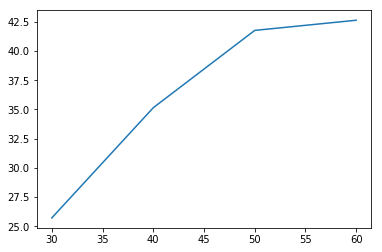

In [12]:
plt.plot(budgets, table_result[-1])

### 3. Be given a cumulative daily budget constraint. Be also given a discretisation for the daily budget values. Apply the Combinatorial-GP-TS to the aggregate curve (we are implicitly assuming that the bidding is performed automatically by the advertising platform) and report how the regret varies in time.

### 4. Focus on a single sub-campaign. Report the the average regression error of the GP as the number of samples increases. The regression error is the maximum error among all the possible arms.

### 5. Suppose to apply, the first day of every week, an algorithm to identify contexts and, therefore, to disaggregate the curves if doing that is the best we can do. And, if such an algorithm suggests disaggregating the curve at time t, then, from t on, keep such curves disaggregate. In order to disaggregate the curve, it is necessary to reason on the features and the values of the features. Apply the Combinatorial-GP-TS algorithm and show, in a plot, how the regret and the reward vary in time (also comparing the regret and the reward of these algorithms with those obtained when the algorithms are applied to the aggregate curve).